In [43]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain

In [44]:
df = pd.read_csv('9748_demo_primary_tweets.csv', delimiter=',')
df.shape

(9748, 13)

In [45]:
df1 = pd.read_csv('bernie sanders.csv', delimiter=',')
df2 = pd.read_csv('elizabeth warren.csv', delimiter=',')
df3 = pd.read_csv('michael bloomberg.csv', delimiter=',')
df4 = pd.read_csv('joe biden.csv', delimiter=',')

In [46]:
df_con = pd.concat([df, df1, df2, df3, df4])
df = df_con.drop_duplicates(subset=['text'])
df.shape

C:\Users\tsblo\Anaconda2\envs\p36workshop\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(17232, 13)

In [47]:
df.head()

,Unnamed: 0,date,favorites,geo,hashtags,id,mentions,permalink,replies,retweets,text,to,username
0,0.0,2019-11-28 04:52:58,0,NaN,NaN,1199914055663857665,@eluning,https://twitter.com/csgazette/status/119991405...,0,0,She's the fifth high-profile candidate to with...,NaN,csgazette
1,1.0,2019-11-28 02:18:01,3,NaN,NaN,1199875060158337025,NaN,https://twitter.com/lacadri34/status/119987506...,1,0,So since certain candidates with zero path to ...,Generalyeo,lacadri34
2,2.0,2019-11-28 01:18:58,1,NaN,NaN,1199860200381014016,NaN,https://twitter.com/frank07093/status/11998602...,1,0,It's been 18 years since 9/11. Barbara Lee was...,DreamReliquary,frank07093
3,3.0,2019-11-27 23:18:46,0,NaN,NaN,1199829951480025088,NaN,https://twitter.com/Fedjsicle/status/119982995...,0,0,The best option for a Democratic Socialist par...,austinyorski,Fedjsicle
4,4.0,2019-11-27 22:27:00,0,NaN,NaN,1199816924110163970,NaN,https://twitter.com/LibbyHa80071391/status/119...,0,0,Many economists view the continued economic gr...,realDonaldTrump,LibbyHa80071391


# Check data

In [48]:
df = df[['date', 'username', 'text']]
df = df.dropna()
df.shape

(17231, 3)

In [49]:
df['date'].min()

'2019-08-01 20:05:21'

In [50]:
df['date'].max()

'2019-11-29 22:11:51'

In [51]:
len(df['username'].value_counts())

13569

# preprocess tweets

In [52]:
%%time
# tokenization = split sentences into word strings
df['tokens'] = df['text'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization = converting a word to its base form, different from stemming
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 7.04 s


# Check frequency

In [53]:
pd.set_option('display.max_rows', 500)

#create [[str, str,...] ...] and chain(*) returns each str in each list 
all_words = pd.Series(chain(*list(df['processed']))) 
word_frequency = all_words.value_counts()
word_frequency

democratic                                                                                                                                                      7891
candidate                                                                                                                                                       6418
presidential                                                                                                                                                    6177
http                                                                                                                                                            5553
…                                                                                                                                                               4723
’                                                                                                                                                               3360
president 

# top 10 candidates

In [54]:
candidate_list = ["bennet", "biden", "bloomberg", "booker", "bullock", "buttigieg",\
                  "castro", "delaney", "babbard", "harris", "klobuchar", "patrick",\
                  "sanders", "sestak", "steyer", "warren", "williamson", "yang"]

In [127]:
tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(candidate_list)
candidate_frequency = word_frequency[mask]
top10_candidates = candidate_frequency.head(4)
top10_candidates

warren       1681
biden        1634
bloomberg    1122
sanders       812
dtype: int64

# lift ratios between candidates

In [128]:
def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

In [129]:
lift_candidates = pd.DataFrame(top10_candidates.index.values, columns=['candidates']) #initialize df 
for candidate in top10_candidates.index.values:
    lift_candidates[candidate] = lift_candidates['candidates'].map(lambda x: lift(x, candidate)) #create lift column for each candidate 
lift_candidates = lift_candidates.set_index('candidates')
lift_candidates

,warren,biden,bloomberg,sanders
candidates,,,,
warren,10.268772,1.513093,0.412585,3.587732
biden,1.513093,10.623305,0.426829,2.032855
bloomberg,0.412585,0.426829,15.384821,0.759744
sanders,3.587732,2.032855,0.759744,21.272840


C:\Users\tsblo\Anaconda2\envs\p36workshop\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


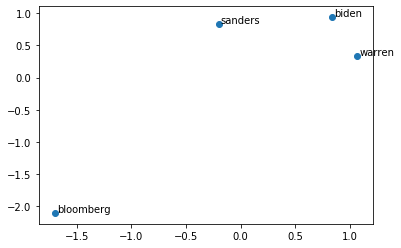

In [130]:
inverse_lift_candidates = lift_candidates.apply(lambda x: 1/x)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline  

embedding = MDS(n_components=2, random_state=10)
mds = embedding.fit_transform(inverse_lift_candidates)
mds_output = pd.DataFrame(mds, index=inverse_lift_candidates.index.values, columns=['x', 'y'])

fig, ax = plt.subplots()
ax.scatter(mds_output['x'], mds_output['y'])
for candidate in inverse_lift_candidates.index.values:
    ax.text(mds_output.loc[candidate, 'x']+0.02, mds_output.loc[candidate, 'y']+0.02, candidate)

# policy connections

In [59]:
word_frequency[:500]

democratic                                                                    7891
candidate                                                                     6418
presidential                                                                  6177
http                                                                          5553
…                                                                             4723
’                                                                             3360
president                                                                     2721
primary                                                                       2309
debate                                                                        2054
since                                                                         1939
trump                                                                         1805
ha                                                                            1688
warr

In [125]:
policy_dict = { "leadership": ["qualified", "leader"],
                "experience":["former", "know", "time", "year"],
                "popularity":["support", "want", "win", "top", "watch", "best", "back", "potential", "great", "believe",\
                              "love", "supporting"],
                "progressive": ["change", "idea", "socialist", "progressive", "liberal", "socialism"], 
                "education": ["school", "college", "university"],
                "taxes": ["tax", "money", "billionaire", "pay", "wealth", "rich"],
                "jobs": ["work", "job"],
                "health": ["health", "care", "live", "life", "medicare", "healthcare"],
                "social": ["women", "family", "choice", "child"],
                "poverty": ["poor", "help"],
                "climate": ["climate"],
                "military": ["military", "war", "fight"],
                "unpopular": ["corrupt", "bad", "hate", "stupid", "corruption", "criminal", "racist"]}

In [132]:
policy_dict = { "leadership": ["qualified", "leader"],
                "experience":["former", "know", "time", "year"],
                "popularity":["support", "want", "win", "top", "watch", "best", "back", "potential", "great", "believe",\
                              "love", "supporting"],
                "progressive": ["change", "idea", "socialist", "progressive", "liberal", "socialism"], 
                "education": ["school", "college", "university"],
                "taxes": ["tax", "money", "billionaire", "pay", "wealth", "rich"],
                "jobs": ["work", "job"],
                "health": ["health", "care", "live", "life", "medicare", "healthcare"],
                "social": ["women", "family", "choice", "child"],
                "poverty": ["poor", "help"],
                "climate": ["climate"],
                "military": ["military", "war", "fight"],
                "unpopular": ["corrupt", "bad", "hate", "stupid", "corruption", "criminal", "racist"],
                "immigration": ['immigrations', "immigrants", "immigration", "immigrant", "migration"],
                "gun": ["gun", "guns", "handgun", "firearm", "pistol", "firearms", "weapon"],
                "economic": ['economic', 'social', 'security', 'financial', "equality", 'inequality', "egalitarianism"],
              "criminal justice": ['justice', 'injustice', 'criminal', 'judicial'],
               "woman rights": ['woman', 'lady', 'women', 'rights', 'liberties'],
              "democracy": ['democracy', 'democracies', "democratization", "autocracy"],
              "lgbt": ['lgbt', 'gay', 'lgbtq', 'lgbtqi']}

In [136]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_policy = pd.DataFrame(pd.Series(policy_dict), columns=['policy_terms'])
top_policy['count'] = top_policy['policy_terms'].map(lambda x: count_attribute(df, x))

top_policy.sort_values(by=['count'], ascending=False)

,policy_terms,count
popularity,"[support, want, win, top, watch, best, back, p...",3271
experience,"[former, know, time, year]",2258
taxes,"[tax, money, billionaire, pay, wealth, rich]",1274
progressive,"[change, idea, socialist, progressive, liberal...",889
health,"[health, care, live, life, medicare, healthcare]",887
unpopular,"[corrupt, bad, hate, stupid, corruption, crimi...",740
social,"[women, family, choice, child]",505
poverty,"[poor, help]",468
education,"[school, college, university]",448
jobs,"[work, job]",438


In [123]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        output[brand] = N*N_ab/(N_a*N_b)
        
    return(output)

In [134]:
from itertools import cycle, islice

candidates_list = top10_candidates[:4]

for attribute in top_policy.index.values:
    output = lift_attribute_to_brands(attribute, policy_dict, candidates_list, df)
    output = pd.Series(output).sort_values(ascending=False)
    print(attribute)
    print(output)
    print('')
#     plt.figure()
#     plt.title(attribute)
#     plt.ylabel("Lift Score")
#     my_colors = list(islice(cycle(['blue']), None, len(df)))
#     output.plot(kind='bar', stacked=True, color=my_colors)

leadership
sanders      0.836050
biden        0.742240
bloomberg    0.671826
warren       0.582943
dtype: float64

experience
bloomberg    1.594353
biden        1.392603
sanders      0.904425
warren       0.800400
dtype: float64

popularity
sanders      1.151114
bloomberg    1.091189
warren       1.051678
biden        1.039272
dtype: float64

progressive
sanders      2.392895
warren       1.363009
bloomberg    0.726842
biden        0.716983
dtype: float64

education
warren       1.856631
sanders      0.949680
biden        0.237127
bloomberg    0.206047
dtype: float64

taxes
bloomberg    3.345051
warren       1.628173
sanders      1.469396
biden        0.500313
dtype: float64

jobs
bloomberg    1.159130
sanders      0.922794
warren       0.726785
biden        0.679115
dtype: float64

health
warren       1.528160
bloomberg    1.110066
sanders      1.079231
biden        0.730577
dtype: float64

social
warren       1.301389
biden        0.883522
sanders      0.800364
bloomberg    0.487440


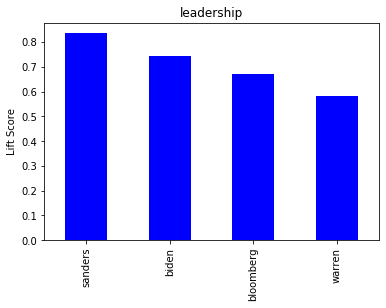

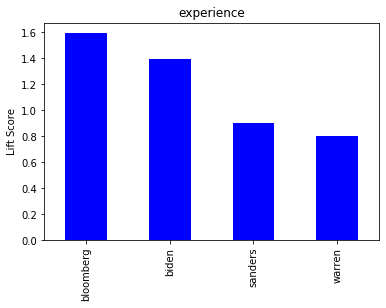

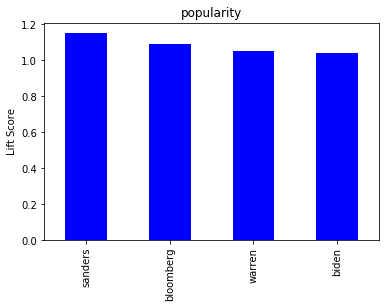

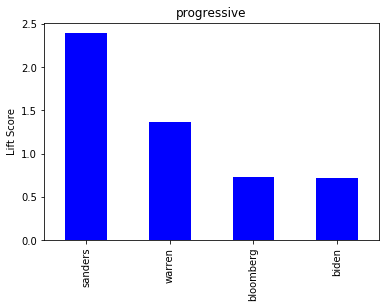

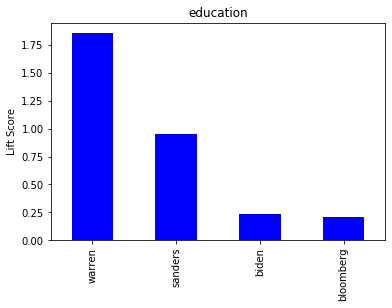

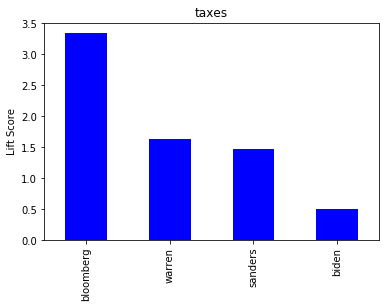

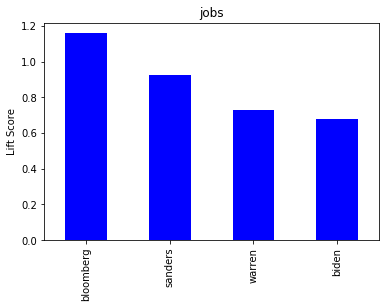

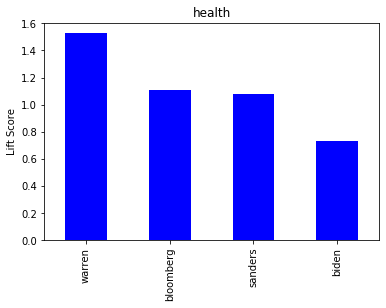

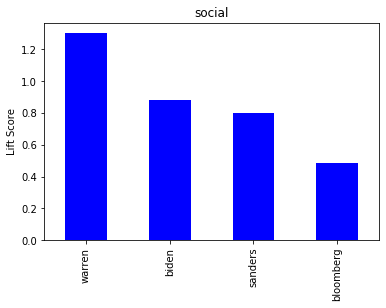

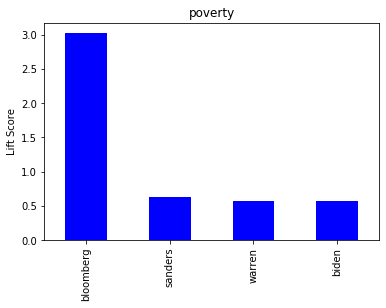

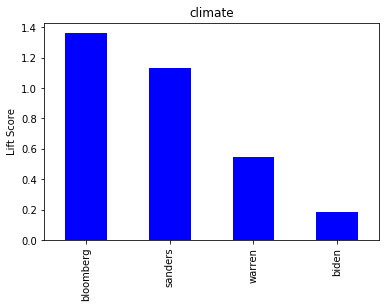

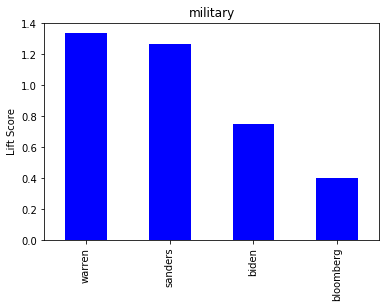

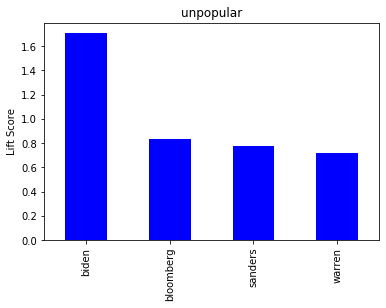

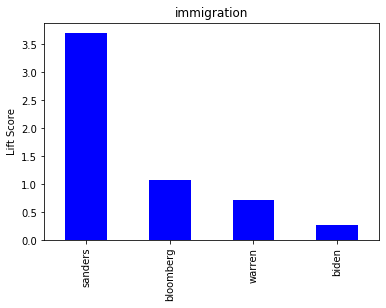

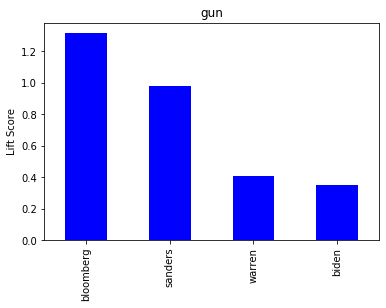

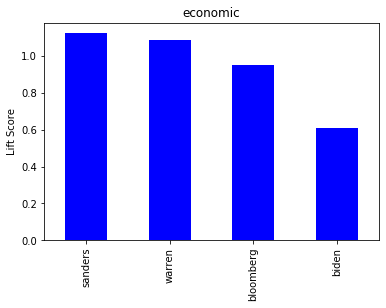

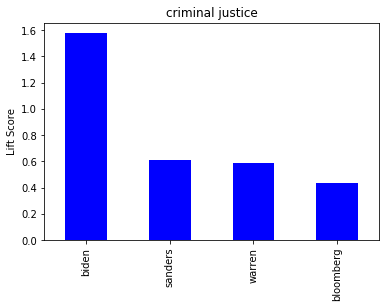

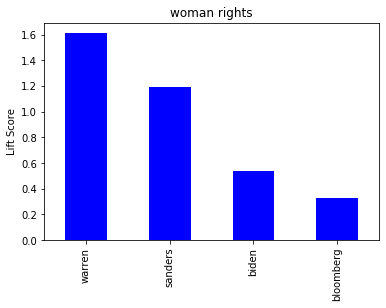

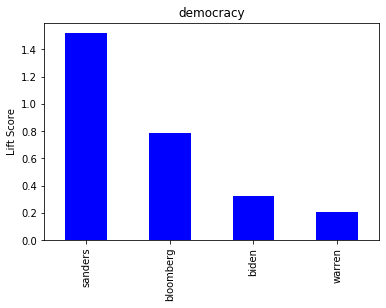

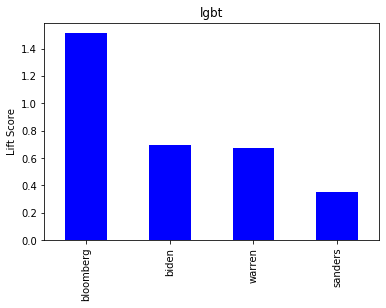

In [135]:
for attribute in top_policy.index.values:
    output = lift_attribute_to_brands(attribute, policy_dict, candidates_list, df)
    output = pd.Series(output).sort_values(ascending=False)
#     print(attribute)
#     print(output)
#     print('')
    plt.figure()
    plt.title(attribute)
    plt.ylabel("Lift Score")
    my_colors = list(islice(cycle(['blue']), None, len(df)))
    output.plot(kind='bar', stacked=True, color=my_colors)

In [88]:
df['bigrams'] = df['tokens'].map(lambda x: list(nltk.bigrams(x)))
df['trigrams'] = df['tokens'].map(lambda x: list(nltk.trigrams(x)))

In [89]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df, bigram=False):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        if bigram == True:
            mask = df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1) | \
                df['bigrams'].map(lambda x: len([term for term in attribute_terms if term in x])>=1) | \
                df['trigrams'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)
            df_a = df[mask]
        else:
            df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        try:
            output[brand] = N*N_ab/(N_a*N_b)
        except:
            output[brand] = None
#         print(brand, N_a, N_b, N, N_ab)    
    return(output)

In [90]:
voting_dict = {"polling": [("vote", "for"), ("i", "support"), ("i", "will", "vote"), ("i", "back"), ("will", "win"),\
                           ("i", "believe", "in"), ("i", "love"), ("i", "supporting")]}

In [91]:
output = lift_attribute_to_brands('polling', voting_dict, candidates_list, df, bigram =True)
output = pd.Series(output).sort_values(ascending=False)
print(output)

biden        0.910569
bloomberg    0.439566
warren       0.293393
sanders      0.000000
dtype: float64
